## Solar Radiation Prediction

> meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

Units:

* Solar radiation: watts per meter^2
* Temperature: degrees Fahrenheit
* Humidity: percent
* Barometric pressure: Hg
* Wind direction: degrees
* Wind speed: miles per hour
* Sunrise/sunset: Hawaii time

### Useful imports and read the data

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Read the data
df = pd.read_csv('data/SolarPrediction.csv', parse_dates=['Data'])
df.shape

(32686, 11)

In [3]:
# Check data format
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,2016-09-29,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,2016-09-29,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,2016-09-29,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,2016-09-29,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,2016-09-29,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


### Feature Engineering

In [5]:
# Convert all dates and times to unix timestamp (timezone doesn't matter now)
df['Data'] = df['Data'].dt.date.astype(str)
df['TimeSunRise'] = df['Data'] + ' ' + df['TimeSunRise']
df['TimeSunSet'] = df['Data'] + ' ' + df['TimeSunSet']
df['Data'] = df['Data'] + ' ' + df['Time']

# Convert to Unix timestamp
fields = ['Data', 'TimeSunRise', 'TimeSunSet']
for x in fields:
    df[x + '_UnixTimeStamp'] = df[x].apply(
        lambda k: int(datetime.strptime(k, "%Y-%m-%d %H:%M:%S").timestamp())
    )

# New sun time field
df['SunTime'] = df['TimeSunSet_UnixTimeStamp'] - df['TimeSunRise_UnixTimeStamp']

# Drop old columns
df.drop('UNIXTime', axis=1, inplace=True)
df.drop('Data', axis=1, inplace=True)
df.drop('Time', axis=1, inplace=True)
df.drop('TimeSunRise', axis=1, inplace=True)
df.drop('TimeSunSet', axis=1, inplace=True)

# Plot head of dataset
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Data_UnixTimeStamp,TimeSunRise_UnixTimeStamp,TimeSunSet_UnixTimeStamp,SunTime
0,1.21,48,30.46,59,177.39,5.62,1475204126,1475140380,1475183580,43200
1,1.21,48,30.46,58,176.78,3.37,1475203823,1475140380,1475183580,43200
2,1.23,48,30.46,57,158.75,3.37,1475203526,1475140380,1475183580,43200
3,1.21,48,30.46,60,137.71,3.37,1475203221,1475140380,1475183580,43200
4,1.17,48,30.46,62,104.95,5.62,1475202924,1475140380,1475183580,43200


### Visualization

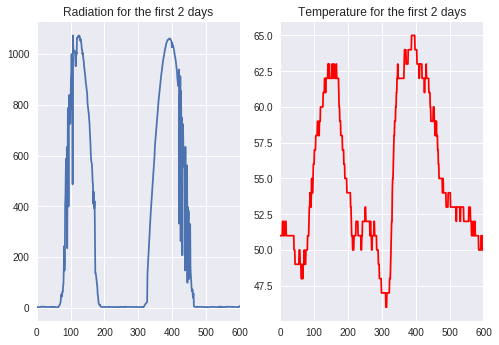

In [6]:
# Plots sorted by time
df.sort_values(by=['Data_UnixTimeStamp'], ascending=[True], inplace=True)

# Radiation and Temperature for the first 2 days
f,axarr = plt.subplots(ncols=2, sharex=True)
axarr[0].set_title('Radiation for the first 2 days')
axarr[1].set_title('Temperature for the first 2 days')
sns.tsplot(data=df['Radiation'][0:600], ax=axarr[0])
sns.tsplot(data=df['Temperature'][0:600], ax=axarr[1], color="r")
plt.show()

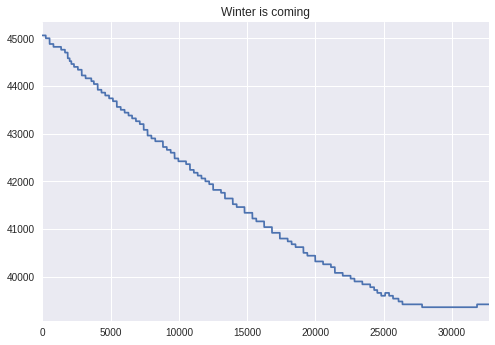

In [7]:
# Plot the sun time
ax = sns.tsplot(data=df['SunTime'])
plt.title('Winter is coming')
plt.show()

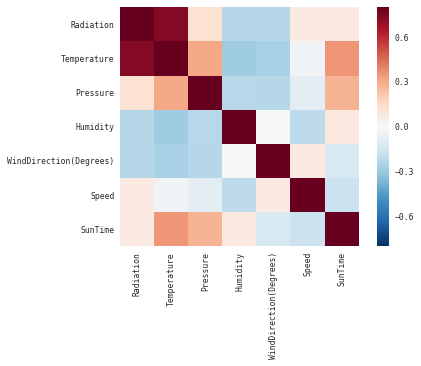

In [8]:
# Heatmap of the dataset
heat_df = df.drop(['Data_UnixTimeStamp','TimeSunRise_UnixTimeStamp','TimeSunSet_UnixTimeStamp'], axis=1)
sns.set(context="paper", font="monospace")

# Get the correlation
corrmat = heat_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots()

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

### Model train

In [9]:
# Create the K-folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle = True)

# Prepare dataset
X = df.drop(['Radiation','Data_UnixTimeStamp','TimeSunRise_UnixTimeStamp','TimeSunSet_UnixTimeStamp'] , axis=1).as_matrix()
y = df['Radiation'].as_matrix()

#### Random Forests

In [10]:
score = []
for train_idx, test_idx in kf.split(X):
    # Separe training and test in the Training set for k-Fold
    fold_Xtrain, fold_Xtest = X[train_idx], X[test_idx]
    fold_ytrain, fold_ytest = y[train_idx], y[test_idx]
    
    # RegrRF
    regr_rf = RandomForestRegressor(max_depth=25, random_state=2)
    regr_rf.fit(fold_Xtrain, fold_ytrain)
    
    # Test on new data
    score_kf = regr_rf.score(fold_Xtest, fold_ytest)
    score.append(score_kf)
    print("RF score=%.2f" % score_kf)
    
    # Plot results
    #pred = regr_rf.predict(fold_Xtest)
    #plt.plot(fold_ytest[0:100], color="b")
    #plt.plot(pred[0:100], color="r")
    #plt.show()
    
print("Mean score: %.2f" % np.mean(score))
print("Std score: %.2f" % np.std(score))

RF score=0.86
RF score=0.85
RF score=0.87
RF score=0.86
RF score=0.85
Mean score: 0.86
Std score: 0.01


#### LSTM

In [11]:
#@TODO NEXT